In [2]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import itertools
import copy

In [38]:
sim_indicators = ["2022-08-26_17-59_1a9e_truncated_shift" + str(i).zfill(2) for i in range(1, 27)]

In [39]:
json_dicts = []
for sim_indicator in sim_indicators:
    path = f"results/raw/{sim_indicator}_results.json"
    contents = Path(path).read_text()
    json_dict = json.loads(contents)
    json_dicts.append(json_dict)

In [40]:
inputs = []
for sim_indicator in sim_indicators:
    path = f"results/raw/{sim_indicator}_inputs.nc"
    da = xr.open_dataarray(path)
    inputs.append(da)

In [41]:
def extract_array(da, modality="tactile", condition="asynch"):
    ar = da.sel(condition=condition, modality=modality).values.squeeze()
    return ar

# Data processing

In [83]:
df_dict = {}
for i, (sim_indicator, da, json_dict) in enumerate(zip(sim_indicators, inputs, json_dicts)):
    shift = i+1
    df_dict[shift] = {}
    for condition in da.condition.values:
        df = pd.DataFrame(columns=["input_visual", "input_tactile", "prob_c1", "slope"])
        log_probs = np.array(json_dict[condition]["mean"])
        probs = np.exp(log_probs)
        df.prob_c1 = probs
        difference = probs[1:] - probs[:-1]
        difference = np.insert(difference, 0, np.nan) #no difference for first entry
        df.slope = difference
        for modality in da.modality.values:
            input_list = list(extract_array(da, condition=condition, modality=modality))
            # first input is a prior
            input_list = [np.nan] + input_list
            df[f"input_{modality}"] = input_list
            df_dict[shift][condition] = df
        df.to_csv(f"results/processed/{sim_indicator}_{condition}.csv", index=False)

# Results

## Do the inputs follow the intended pattern?

### symmetry

code name: **affair**

/tmp/ipykernel_34962/1138990570.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


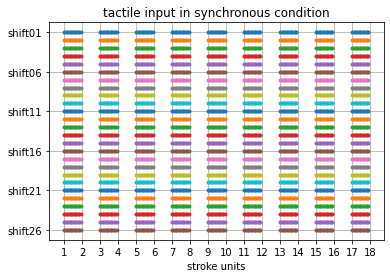

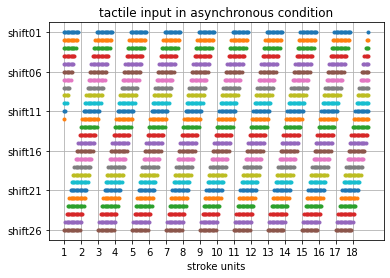

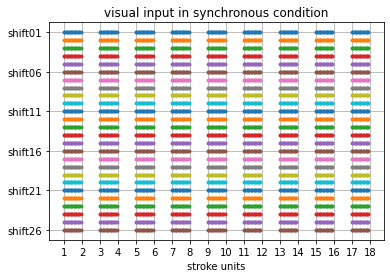

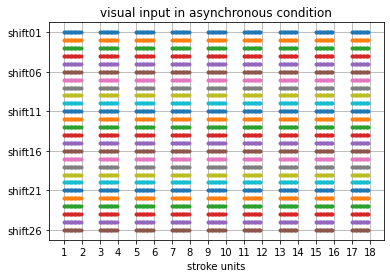

In [83]:
for modality in ["tactile", "visual"]:
    for condition in ["synch", "asynch"]:
        fig, ax = plt.subplots()
        for shift, da in enumerate(inputs):
            ar = da.sel(condition=condition, modality=modality).values.squeeze()
            ar[ar==0] = np.nan
            #-1 cancels out the 1s in ar, so that we are plotted at y=-shift
            #-shift, because the plot is supposed to be read from top to botton
            ax.plot(range(len(ar)), (ar-1)-shift, ".")
            ax.set_title(f"{modality} input in {condition}ronous condition")
        xticks = np.arange(0,len(ar),13)
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.arange(len(xticks))+1)
        ax.set_xlabel("stroke units")
        ax.set_yticks(-np.arange(0,shift+1,5))
        ylabels = [f"shift{str(shift).zfill(2)}" for shift in np.arange(1,len(inputs)+1,5)]
        ax.set_yticklabels(ylabels)
        ax.grid(True)
        fig.show()
        if modality=="tactile" and condition=="asynch":
            fig.savefig("input_asynchTactile.jpg", dpi=200, bbox_inches="tight")

The above graphs look good. I wasn't quite sure about asynchronous tactile, because it isn't quite symmetrical on the y axis. So I double-checked:

In [62]:
da = inputs[-1]
da.sel(modality="tactile", condition="asynch").values.squeeze()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0.

This is as it should be. It starts with a full-length stroke and ends with a full-length pause. The asymmetricality is due to me omitting shift00, while including shift26.

### absolute

code name: **overbold**

Here are visual vs. tactile for shift25, just because I explicitly named that one in the notes:

In [66]:
da = inputs[24]
da.sel(modality="visual", condition="asynch").values.squeeze()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0.

In [67]:
da.sel(modality="tactile", condition="asynch").values.squeeze()

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0.

### Symmetricality

In [77]:
half_length = int((len(inputs)-1)/2)
for i in range(half_length):
    front_ar = extract_array(inputs[i+1])
    back_ar = extract_array(inputs[-i])
front_ar == back_ar

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

## asynchronous < random

Code name: **reason** (Hectate)

In [82]:
df_reason = pd.DataFrame(columns=['shift', 'asynch', 'random', 'asynch_smaller'])
for i, json_dict in enumerate(json_dicts):
    final_asynch = json_dict['asynch']['mean'][-1]
    final_random = json_dict['random']['mean'][-1]
    df_reason.loc[i, 'shift'] = i+1
    df_reason.loc[i, 'asynch'] = round(final_asynch)
    df_reason.loc[i, 'random'] = round(final_random)
    df_reason.loc[i, 'asynch_smaller'] = final_asynch < final_random

In [83]:
df_reason

shift  asynch  random asynch_smaller
0      1       0  -16144          False
1      2   -7353  -16144          False
2      3  -15117  -16144          False
3      4  -23020  -16144           True
4      5  -31023  -16144           True
5      6  -39111  -16144           True
6      7  -47275  -16144           True
7      8  -55513  -16144           True
8      9  -63822  -12384           True
9     10  -72202  -12384           True
10    11  -80653  -12384           True
11    12  -89213  -12384           True
12    13  -97476  -12384           True
13    14  -90414  -12384           True
14    15  -82508  -12384           True
15    16  -74533  -12384           True
16    17  -66488  -12936           True
17    18  -58373  -12936           True
18    19  -50191  -12936           True
19    20  -41942  -12936           True
20    21  -33631  -12936           True
21    22  -25264  -12936           True
22    23  -16861  -12936           True
23    24   -8461  -12936          False
24    25    -202  -16807          False
25    26       0  -16807          False

## the final asynch probabilities form a valley

Code name: **beldam** (Hectate)

<AxesSubplot:>

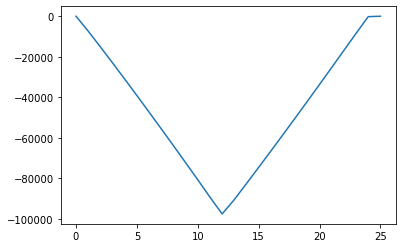

In [91]:
df_reason.asynch.plot()

## Does the asynchronous input get smaller and smaller?

Code name: **saucy** (Hectate)

In [70]:
df = pd.DataFrame(columns=['shift'])
for dict_i, json_dict in enumerate(json_dicts):
    is_shrinking = True
    asynch_probs = json_dict['asynch']['mean']
    for prob_i in range(1, len(asynch_probs)):
        is_shrinking &= asynch_probs[prob_i] < asynch_probs[prob_i-1]
    df.loc[dict_i, 'shift'] = dict_i+1
    df.loc[dict_i, 'is_shrinking'] = is_shrinking

In [71]:
df

shift is_shrinking
0      1        False
1      2        False
2      3        False
3      4        False
4      5        False
5      6        False
6      7        False
7      8        False
8      9        False
9     10        False
10    11        False
11    12        False
12    13         True
13    14         True
14    15         True
15    16         True
16    17         True
17    18         True
18    19         True
19    20         True
20    21         True
21    22         True
22    23         True
23    24         True
24    25        False
25    26        False

### special case 25

In [78]:
df25 = pd.DataFrame()
json_dict = json_dicts[24]
probs = json_dict['asynch']['mean']
is_shrinking = True
for i in range(1, len(probs)):
    is_shrinking &= probs[i] < probs[i-1]
    df25.loc[i, 'is_shrinking'] = is_shrinking

In [81]:
df25.loc[10:20]

is_shrinking
10         True
11         True
12         True
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False

---

## Is the synchronous input the same across the board?
code name: **dare**

In [47]:
def is_identical(df_dict):
    is_identical = True
    for shift in list(df_dict)[1:]:
        for modality in itertools.product(["visual", "tactile"], repeat=2):
            dfA = df_dict[shift-1]["synch"]
            dfB = df_dict[shift]["synch"]
            is_identical &= all(dfA["prob_"+modality[0]] == dfB["prob_"+modality[1]])
    return is_identical

In [48]:
result = is_identical(df_dict)
result

True

Sanity check for the test itself: Is the result `False` if we change one of the values?

In [49]:
manipulated_dict = copy.deepcopy(df_dict)
manipulated_dict[13]["synch"].loc[150, "prob_visual"] = 42

In [50]:
result = is_identical(manipulated_dict)
result

False

## Does agreement slow down the decrease in probability?
code name: **death**

In [56]:
pd.set_option('display.max_rows', None)

In [57]:
df_results = pd.DataFrame()
for shift in df_dict:
    df_probs = df_dict[shift]["asynch"]
    slopes_at_agreement = df_probs.loc[df_probs.input_visual == df_probs.input_tactile, "slope"]
    agreement_mean = slopes_at_agreement.mean()
    df_results.loc[shift, "agreement"] = agreement_mean
    slopes_at_disagreement = df_probs.loc[df_probs.input_visual != df_probs.input_tactile, "slope"]
    disagreement_mean = slopes_at_disagreement.mean()
    df_results.loc[shift, "disagreement"] = disagreement_mean
    df_results.loc[shift, "agreement_smaller"] = agreement_mean < disagreement_mean
df_results

agreement  disagreement agreement_smaller
1    4.622680e-03  8.340020e-05             False
2    2.511817e-08 -1.381506e-07             False
3    5.987377e-09 -1.995835e-08             False
4    1.531661e-09 -3.446556e-09             False
5    4.325808e-10 -6.923843e-10             False
6    1.352647e-10 -1.580213e-10             False
7    4.698758e-11 -4.045726e-11             False
8    1.819636e-11 -1.153214e-11             False
9    7.875690e-12 -3.642006e-12             False
10   3.808632e-12 -1.270119e-12             False
11   2.046193e-12 -4.879713e-13             False
12   1.199770e-12 -2.062556e-13             False
13            NaN -9.809982e-14             False
14 -3.733643e-137 -1.062748e-13             False
15 -5.445224e-118 -1.159362e-13             False
16 -2.375320e-100 -1.275298e-13             False
17  -2.614685e-84 -1.416997e-13             False
18  -6.884717e-70 -1.594122e-13             False
19  -4.232740e-57 -1.821854e-13             False
20  -5.993956e-46 -2.125496e-13             False
21  -1.936540e-36 -2.550595e-13             False
22  -1.414766e-28 -3.188244e-13             False
23  -2.310281e-22 -4.250992e-13             False
24  -8.275545e-18 -6.376033e-13             False
25  -6.259546e-15 -1.200183e-12             False
26   4.273504e-03           NaN             False

<AxesSubplot:>

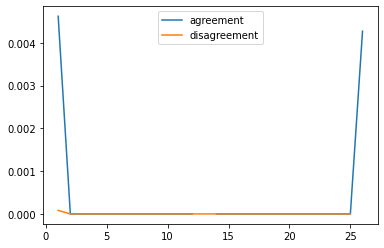

In [61]:
df_results[["agreement", "disagreement"]].plot()

Text(0, 0.5, 'average slope')

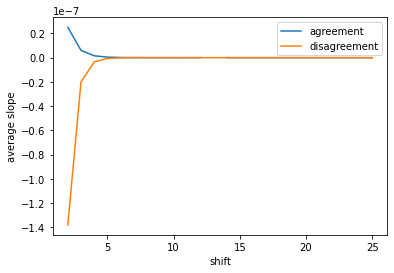

In [91]:
# remove the outliers
ax = df_results.loc[2:25, ["agreement", "disagreement"]].plot()
ax.set_xlabel("shift")
ax.set_ylabel("average slope")